## AMEX Default Prediction using XGBoost

This notebook trained an XGBoost model using the dataset from [AMEX data - integer dtypes - parquet format](https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format), which provides a data file format designed for efficient data storage and retrieval and can help to solve the memory problem. Also, this notebook used [CuPy](https://cupy.dev/), which utilizes CUDA Toolkit to accelerate computing. Then used feature engineering methods provided by [Amex Agg Data How It Created](https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created).

This XGB model achieved LB 0.792.

## Load Libraries

In [1]:
# LOAD LIBRARIES
import pandas as pd 
import numpy as np # CPU libraries
import cupy # GPU libraries
import matplotlib.pyplot as plt, gc, os

In [2]:
# Set random seed
SEED = 42

## 1. Data Preprocessing

### 1.1 Read Data

In [3]:
# Read data
# transfer customer_ID from hex to int

def read_file(path = '', usecols = None):
    # LOAD DATAFRAME
    if usecols is not None: df = pd.read_parquet(path, columns=usecols)
    else: df = pd.read_parquet(path)
    # REDUCE DTYPE FOR CUSTOMER AND DATE
    #df['customer_ID'] = df['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    df['customer_ID'] = df['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int64')
    df.S_2 = pd.to_datetime( df.S_2 )
    # SORT BY CUSTOMER AND DATE (so agg('last') works correctly)
    #df = df.sort_values(['customer_ID','S_2'])
    #df = df.reset_index(drop=True)
    # FILL NAN
    #df = df.fillna(NAN_VALUE)
    print('shape of data:', df.shape)
    return df

print('Reading train data...')
TRAIN_PATH = 'F:/Pythondata/AMEX/AMEXparquet/train.parquet'
train = read_file(path = TRAIN_PATH)

Reading train data...
shape of data: (5531451, 190)


In [4]:
train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,-4532153018459703766,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,NaN,0,0.000610,0
1,-4532153018459703766,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,NaN,0,0.005492,0
2,-4532153018459703766,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,NaN,0,0.006986,0
3,-4532153018459703766,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,NaN,0,0.006527,0
4,-4532153018459703766,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,NaN,0,0.008126,0


### 1.2 Feature Engineering

In [5]:
# Aggregate data
# Group by Customer_ID

def process_and_feature_engineer(df):
    # FEATURE ENGINEERING FROM 
    # https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
    all_cols = [c for c in list(df.columns) if c not in ['customer_ID','S_2']]
    cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
    num_features = [col for col in all_cols if col not in cat_features]

    test_num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

    test_cat_agg = df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]

    df = pd.concat([test_num_agg, test_cat_agg], axis=1)
    del test_num_agg, test_cat_agg
    print('shape after engineering', df.shape )
    
    return df

train = process_and_feature_engineer(train)

shape after engineering (458913, 918)


In [6]:
# Add Targets
targets = pd.read_csv('F:/Pythondata/AMEX/AMEXdata/train_labels.csv')
targets['customer_ID'] = targets['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int64')
targets = targets.set_index('customer_ID')
train = train.merge(targets, left_index=True, right_index=True, how='left')
del targets

# NEEDED TO MAKE CV DETERMINISTIC (cudf merge above randomly shuffles rows)
train = train.sort_index().reset_index()

# Check features
FEATURES = train.columns[1:-1]
print(f'There are {len(FEATURES)} features!')

There are 918 features!


In [7]:
train.head()

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,...,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique,target
0,-9223358381327749917,0.415868,0.057145,0.340178,0.498727,0.387708,2.615385,4.628507,0,16,...,13,2,1,13,-1,1,13,3,2,1
1,-9223193039457028513,0.974068,0.013094,0.964483,1.002478,1.001372,0.000000,0.000000,0,0,...,13,0,1,13,-1,1,13,6,1,0
2,-9223189665817919541,0.802447,0.038025,0.694073,0.828761,0.694073,0.000000,0.000000,0,0,...,13,0,1,13,-1,1,13,6,1,0
3,-9223188534444851899,0.791203,0.002688,0.786647,0.794826,0.787945,0.000000,0.000000,0,0,...,13,3,2,13,-1,1,13,5,1,0
4,-9223173911659837606,0.115666,0.078554,0.038207,0.252421,0.040486,4.384615,6.144625,0,17,...,13,0,2,13,-1,1,13,6,2,1


## 2. Modeling

### 2.1 Model Building

In [9]:
import xgboost as xgb
from xgboost import XGBClassifier

In [10]:
# Split training dataset into features and target
x_train = train.drop(['target'], axis = 1)
y_train = train.target

# Release memory
del train

In [11]:
x_train

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,...,D_63_nunique,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique
0,-9223358381327749917,0.415868,0.057145,0.340178,0.498727,0.387708,2.615385,4.628507,0,16,...,1,13,2,1,13,-1,1,13,3,2
1,-9223193039457028513,0.974068,0.013094,0.964483,1.002478,1.001372,0.000000,0.000000,0,0,...,2,13,0,1,13,-1,1,13,6,1
2,-9223189665817919541,0.802447,0.038025,0.694073,0.828761,0.694073,0.000000,0.000000,0,0,...,1,13,0,1,13,-1,1,13,6,1
3,-9223188534444851899,0.791203,0.002688,0.786647,0.794826,0.787945,0.000000,0.000000,0,0,...,1,13,3,2,13,-1,1,13,5,1
4,-9223173911659837606,0.115666,0.078554,0.038207,0.252421,0.040486,4.384615,6.144625,0,17,...,1,13,0,2,13,-1,1,13,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458908,9223275399009481284,0.508722,0.034856,0.446763,0.580708,0.502093,3.769231,8.427671,0,31,...,1,13,3,1,13,-1,1,13,6,1
458909,9223300670094807586,0.128279,0.138331,-0.035435,0.395510,0.118304,5.461538,6.213096,1,22,...,1,13,3,2,13,-1,1,13,5,2
458910,9223303087902649707,0.364807,0.074824,0.271125,0.517709,0.368901,3.692308,8.576952,0,23,...,1,13,2,1,13,-1,1,13,3,2
458911,9223345210145379887,0.848886,0.059538,0.776463,0.940112,0.902587,4.000000,7.118052,0,23,...,1,13,2,1,13,-1,1,13,6,1


In [12]:
y_train

0         1
1         0
2         0
3         0
4         1
         ..
458908    0
458909    1
458910    1
458911    0
458912    1
Name: target, Length: 458913, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split

# Split data into training dataset and validation dataset
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train, y_train, test_size=0.25, random_state=SEED)

In [14]:
y_train_split

386386    1
278647    0
386681    0
90569     0
423304    1
         ..
259178    0
365838    0
131932    0
146867    0
121958    1
Name: target, Length: 344184, dtype: int64

In [15]:
x_train_split

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,...,D_63_nunique,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique
386386,6306055800867252698,0.352431,0.097295,0.115014,0.457894,0.115014,7.307692,12.051173,0,31,...,1,13,0,2,13,-1,1,13,6,2
278647,1978991304859019498,0.553108,0.059027,0.446671,0.631536,0.565137,0.000000,0.000000,0,0,...,1,13,3,1,13,1,3,13,3,3
386681,6317997466174465176,0.607867,0.055155,0.510382,0.680685,0.674414,2.100000,5.300943,0,17,...,1,10,2,2,10,-1,1,10,5,2
90569,-5594562990419688087,0.823604,0.009203,0.800465,0.834511,0.834511,0.230769,0.438529,0,1,...,1,13,0,2,13,-1,2,13,6,2
423304,7787134089477281285,0.419951,0.031765,0.391676,0.447786,0.447121,2.750000,4.856267,0,10,...,1,4,3,2,4,-1,1,4,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,1187752144874293080,0.865653,0.044947,0.800558,0.968731,0.968731,2.076923,5.073814,0,14,...,1,13,0,1,13,-1,1,13,6,1
365838,5478153199592555347,0.778278,0.011370,0.764371,0.804988,0.782975,0.076923,0.277350,0,1,...,1,13,0,1,13,-1,1,13,5,1
131932,-3932746752766853590,0.726989,0.018089,0.704152,0.750933,0.750068,0.000000,0.000000,0,0,...,1,13,0,1,13,-1,1,13,5,1
146867,-3324177553606337370,0.654020,0.075051,0.539239,0.741222,0.677474,2.076923,2.361551,0,5,...,1,13,0,1,13,-1,1,13,6,1


In [16]:
# Load training dataset
dtrain = xgb.DMatrix(x_train_split, label = y_train_split)

In [17]:
# Build XGB Model
model = XGBClassifier(objective='binary:logistic', 
                      n_estimators=300,
                      seed=123,
                      use_label_encoder=False,
                      eval_metric='aucpr', # updated to make use of the aucpr option
                      early_stopping_rounds=200,
                      tree_method='gpu_hist',
                      enable_categorical=True
                      )
val_set = [(x_val_split, y_val_split)]

### 2.2 Fit Model

In [18]:
# Fit Model
model.fit(x_train_split, y_train_split, eval_set= val_set, verbose = True)

[0]	validation_0-aucpr:0.83862
[1]	validation_0-aucpr:0.85350
[2]	validation_0-aucpr:0.85837
[3]	validation_0-aucpr:0.86279
[4]	validation_0-aucpr:0.86577
[5]	validation_0-aucpr:0.86862
[6]	validation_0-aucpr:0.87083
[7]	validation_0-aucpr:0.87326
[8]	validation_0-aucpr:0.87445
[9]	validation_0-aucpr:0.87578
[10]	validation_0-aucpr:0.87717
[11]	validation_0-aucpr:0.87857
[12]	validation_0-aucpr:0.87948
[13]	validation_0-aucpr:0.88031
[14]	validation_0-aucpr:0.88113
[15]	validation_0-aucpr:0.88185
[16]	validation_0-aucpr:0.88260
[17]	validation_0-aucpr:0.88333
[18]	validation_0-aucpr:0.88413
[19]	validation_0-aucpr:0.88471
[20]	validation_0-aucpr:0.88520
[21]	validation_0-aucpr:0.88559
[22]	validation_0-aucpr:0.88610
[23]	validation_0-aucpr:0.88657
[24]	validation_0-aucpr:0.88683
[25]	validation_0-aucpr:0.88711
[26]	validation_0-aucpr:0.88736
[27]	validation_0-aucpr:0.88765
[28]	validation_0-aucpr:0.88783
[29]	validation_0-aucpr:0.88803
[30]	validation_0-aucpr:0.88825
[31]	validation_0-

[252]	validation_0-aucpr:0.88753
[253]	validation_0-aucpr:0.88754
[254]	validation_0-aucpr:0.88758
[255]	validation_0-aucpr:0.88753
[256]	validation_0-aucpr:0.88752
[257]	validation_0-aucpr:0.88750
[258]	validation_0-aucpr:0.88751
[259]	validation_0-aucpr:0.88748
[260]	validation_0-aucpr:0.88746
[261]	validation_0-aucpr:0.88749
[262]	validation_0-aucpr:0.88748
[263]	validation_0-aucpr:0.88743
[264]	validation_0-aucpr:0.88739
[265]	validation_0-aucpr:0.88739
[266]	validation_0-aucpr:0.88735
[267]	validation_0-aucpr:0.88734
[268]	validation_0-aucpr:0.88734
[269]	validation_0-aucpr:0.88730
[270]	validation_0-aucpr:0.88728
[271]	validation_0-aucpr:0.88734
[272]	validation_0-aucpr:0.88736
[273]	validation_0-aucpr:0.88734
[274]	validation_0-aucpr:0.88733
[275]	validation_0-aucpr:0.88731
[276]	validation_0-aucpr:0.88733
[277]	validation_0-aucpr:0.88731
[278]	validation_0-aucpr:0.88726
[279]	validation_0-aucpr:0.88719
[280]	validation_0-aucpr:0.88723
[281]	validation_0-aucpr:0.88718
[282]	vali

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=200, enable_categorical=True,
              eval_metric='aucpr', gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, ...)

In [19]:
# AMEX Default scoring metrics, use this to check scoring
# https://www.kaggle.com/kyakovlev
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

In [20]:
# Check accuracy using Sklearn metrics accuracy score
from sklearn.metrics import accuracy_score
preds = model.predict(x_val_split)
print(accuracy_score(y_val_split, preds))

0.8994848730486625


In [21]:
# Predict probability for each customer
# The task is to predict the probability of a future payment default, so we use probability here
preds_prob = model.predict_proba(x_val_split)
preds_prob

array([[0.9936834 , 0.00631658],
       [0.10171503, 0.898285  ],
       [0.99857306, 0.00142694],
       ...,
       [0.9382165 , 0.06178349],
       [0.9876453 , 0.01235466],
       [0.9981807 , 0.00181929]], dtype=float32)

In [22]:
# Show result
display(preds_prob[:,1])

array([0.00631658, 0.898285  , 0.00142694, ..., 0.06178349, 0.01235466,
       0.00181929], dtype=float32)

### 2.3 Evaluation

#### 2.3.1 ROC

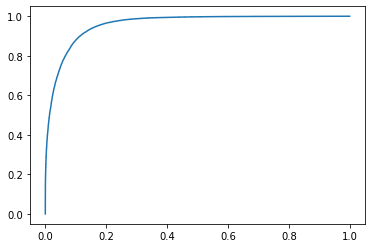

In [23]:
# Plot ROC
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(y_val_split, preds_prob[:,1])

plt.plot(fpr, tpr)
plt.show()

In [24]:
# Calculate score based on AMEX metrics
amex_metric_mod(y_val_split, preds_prob[:,1])

0.7789830576284045

#### 2.3.2 Feature Importance

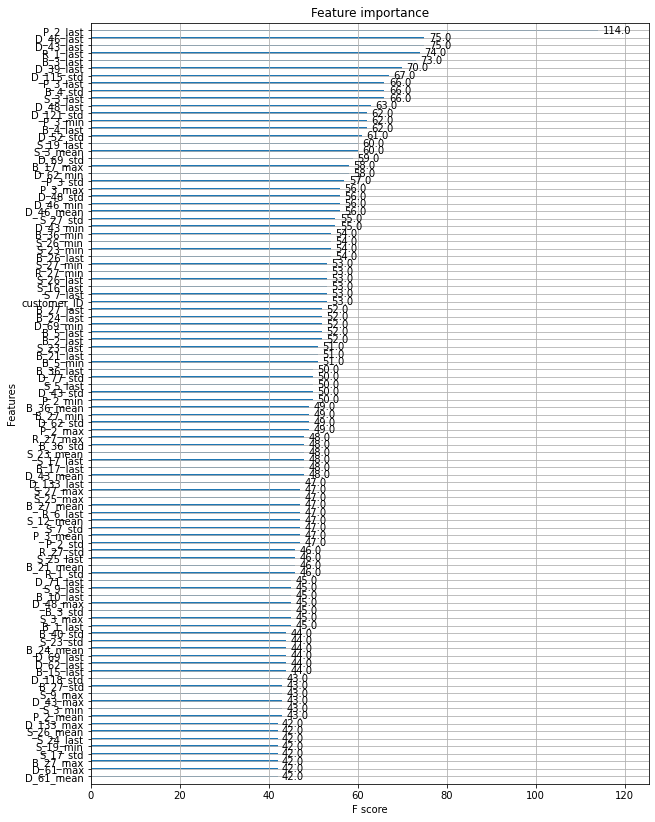

In [25]:
from xgboost import plot_importance

# Review the important features
# print(xg_cl.feature_importances_)
def plot_features(booster, figsize, max_num_features=100):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, max_num_features=max_num_features)
plot_features(model, (10,14))
plt.show()

### 2.4 CV Methods

In [26]:
# Set XGB parameters
xgb_params = { 
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'max_depth':6, 
    'learning_rate':0.5, 
    'subsample':0.8,
    'colsample_bytree':0.6, 
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
}

In [27]:
cv1 = xgb.cv(xgb_params, dtrain, num_boost_round = 999, nfold = 5, 
                early_stopping_rounds = 200, verbose_eval = 20)

[0]	train-logloss:0.44217+0.00018	test-logloss:0.44342+0.00065
[20]	train-logloss:0.20833+0.00045	test-logloss:0.23269+0.00079
[40]	train-logloss:0.19033+0.00051	test-logloss:0.23456+0.00082
[60]	train-logloss:0.17625+0.00082	test-logloss:0.23834+0.00083
[80]	train-logloss:0.16322+0.00021	test-logloss:0.24238+0.00070
[100]	train-logloss:0.15108+0.00056	test-logloss:0.24648+0.00057
[120]	train-logloss:0.14052+0.00086	test-logloss:0.25032+0.00025
[140]	train-logloss:0.13003+0.00091	test-logloss:0.25412+0.00033
[160]	train-logloss:0.11996+0.00106	test-logloss:0.25815+0.00036
[180]	train-logloss:0.11107+0.00117	test-logloss:0.26175+0.00063
[200]	train-logloss:0.10288+0.00104	test-logloss:0.26517+0.00088
[220]	train-logloss:0.09529+0.00117	test-logloss:0.26858+0.00067
[221]	train-logloss:0.09496+0.00112	test-logloss:0.26872+0.00069


In [28]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':[2,4,6],
             'n_estimaters':[100, 150, 200],
             'learning_rate:': [0.01, 0.05, 0.1, 0.15]}
clf = XGBClassifier()
grid_search = GridSearchCV(clf, parameters, scoring='roc_auc', cv=5)

In [ ]:
# Find the best hyperparameters
grid_search.fit(x_train, y_train)

grid_search.best_params_

#### After CV grid search, the best hyperparameters are: {'max_depth': 4, 'n_estimaters': 100, 'learning_rate': 0.01}
Setting learning_rate as $0.01$ is pretty **dangerous**, beacuase it requires great amount of memory and it's very easy to get your kernel killed.

In [29]:
# Review the best hyperparameters
xgb_params = { 
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'max_depth':4, 
    'learning_rate':0.01, 
    'n_estimaters':100,
    'subsample':0.8,
    'colsample_bytree':0.6, 
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
}

## 3. Deployment

### 3.1 Training Model

In [30]:
# Load training dataset.
dval = xgb.DMatrix(x_val_split, label = y_val_split)

In [31]:
# Training model
xgb_clf = xgb.train(xgb_params,
                   dtrain,
                   num_boost_round = 10000,
                   evals=[(dtrain, 'train'),(dval, 'valid')],
                   early_stopping_rounds = 100,
                   verbose_eval = 20)

[21:46:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimaters" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.68678	valid-logloss:0.68679
[20]	train-logloss:0.58241	valid-logloss:0.58253
[40]	train-logloss:0.50734	valid-logloss:0.50758
[60]	train-logloss:0.45201	valid-logloss:0.45236
[80]	train-logloss:0.40984	valid-logloss:0.41035
[100]	train-logloss:0.37714	valid-logloss:0.37779
[120]	train-logloss:0.35156	valid-logloss:0.35234
[140]	train-logloss:0.33116	valid-logloss:0.33206
[160]	train-logloss:0.31475	valid-logloss:0.31573
[180]	train-logloss:0.30149	valid-logloss:0.30257
[200]	train-logloss:0.29069	valid-logloss:0.29187
[220]	train-logloss:0.28173	valid-l

[3080]	train-logloss:0.20446	valid-logloss:0.21840
[3100]	train-logloss:0.20435	valid-logloss:0.21838
[3120]	train-logloss:0.20425	valid-logloss:0.21836
[3140]	train-logloss:0.20414	valid-logloss:0.21833
[3160]	train-logloss:0.20403	valid-logloss:0.21829
[3180]	train-logloss:0.20392	valid-logloss:0.21826
[3200]	train-logloss:0.20382	valid-logloss:0.21824
[3220]	train-logloss:0.20371	valid-logloss:0.21822
[3240]	train-logloss:0.20361	valid-logloss:0.21820
[3260]	train-logloss:0.20350	valid-logloss:0.21817
[3280]	train-logloss:0.20340	valid-logloss:0.21815
[3300]	train-logloss:0.20329	valid-logloss:0.21812
[3320]	train-logloss:0.20318	valid-logloss:0.21810
[3340]	train-logloss:0.20308	valid-logloss:0.21808
[3360]	train-logloss:0.20298	valid-logloss:0.21805
[3380]	train-logloss:0.20287	valid-logloss:0.21803
[3400]	train-logloss:0.20277	valid-logloss:0.21801
[3420]	train-logloss:0.20266	valid-logloss:0.21799
[3440]	train-logloss:0.20256	valid-logloss:0.21797
[3460]	train-logloss:0.20246	va

[6300]	train-logloss:0.18985	valid-logloss:0.21641
[6320]	train-logloss:0.18977	valid-logloss:0.21640
[6340]	train-logloss:0.18969	valid-logloss:0.21640
[6360]	train-logloss:0.18961	valid-logloss:0.21640
[6380]	train-logloss:0.18953	valid-logloss:0.21639
[6400]	train-logloss:0.18945	valid-logloss:0.21639
[6420]	train-logloss:0.18937	valid-logloss:0.21638
[6440]	train-logloss:0.18929	valid-logloss:0.21637
[6460]	train-logloss:0.18921	valid-logloss:0.21636
[6480]	train-logloss:0.18913	valid-logloss:0.21637
[6500]	train-logloss:0.18905	valid-logloss:0.21635
[6520]	train-logloss:0.18897	valid-logloss:0.21635
[6540]	train-logloss:0.18889	valid-logloss:0.21634
[6560]	train-logloss:0.18881	valid-logloss:0.21634
[6580]	train-logloss:0.18873	valid-logloss:0.21634
[6600]	train-logloss:0.18865	valid-logloss:0.21633
[6620]	train-logloss:0.18857	valid-logloss:0.21632
[6640]	train-logloss:0.18848	valid-logloss:0.21631
[6660]	train-logloss:0.18840	valid-logloss:0.21631
[6680]	train-logloss:0.18833	va

[9520]	train-logloss:0.17776	valid-logloss:0.21588
[9540]	train-logloss:0.17768	valid-logloss:0.21589
[9551]	train-logloss:0.17764	valid-logloss:0.21588


In [35]:
# Release Memory
del dtrain, dval
del x_train_split, y_train_split, x_val_split, y_val_split, cv1

### 3.2 Process and Feature Engineer Test Dataset

In [ ]:
# Read test dataset
TEST_PATH = 'F:/Pythondata/AMEX/AMEXparquet/test.parquet'
test = read_file(path = TEST_PATH)

# Process and Feature Engineer test dataset
test = process_and_feature_engineer(test)
test = test.sort_index().reset_index()

# FEATURES
FEATURES = test.columns[1:-1]
print(f'There are {len(FEATURES)} features!')

shape of data: (11363762, 190)


In [ ]:
test

In [38]:
# Load test dataset
dtest = xgb.DMatrix(data = test)

### 3.3 Make submission

In [39]:
# Score up the test dataset
test_preds = xgb_clf.predict(dtest)
test_preds

array([0.00876061, 0.00470268, 0.00962512, ..., 0.00130638, 0.00218794,
       0.02023417], dtype=float32)

In [ ]:
customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
test = pd.DataFrame(index = customers, data = {'prediction':test_preds})

In [57]:
# Write submission
sub = pd.read_csv('F:/Pythondata/AMEX/sample_submission/sample_submission.csv', usecols= ['customer_ID'])
sub['customer_ID_hash'] = sub['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int64')
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test[['prediction']], left_index = True, right_index = True, how = 'left')
sub = sub.reset_index(drop=True)

In [58]:
sub

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.033948
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000953
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.067301
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.203578
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.862242
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,0.018280
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,0.737053
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.464169
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,0.225945


In [60]:
# Display predictions
sub.to_csv('submission.csv',index=False)
print('Submission file shape is', sub.shape)
sub.head()

Submission file shape is (924621, 2)


,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.033948
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000953
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.067301
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.203578
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.862242
